# Chapter 4, Exercise 2: Full MNIST

> Complete all the steps in this chaper using the full MNIST dataset, not just 3s and 7s.

I'm going to follow most of the steps...I'm going to skip the parts about solving the linear equation.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(42) # Life, the Universe, and Everything

from fastai.vision.all import *

The [fast.ai datasets](https://course.fast.ai/datasets) include MNIST, not just the sample -- so let's do that.

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/home/aardvark/.fastai/data/mnist_png/training'),Path('/home/aardvark/.fastai/data/mnist_png/testing')]

Let's look at a random 8:

In [3]:
eights = (path / 'training/8').ls().sorted()
im8_path = eights[1]
im8 = Image.open(im8_path)
im8

Let's compare tensors and arrays:

In [4]:
array(im8)[5:15, 5:15]

array([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
       [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
       [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
       [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
       [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
       [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
       [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
       [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
       [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=uint8)

In [5]:
tensor(im8)[5:15, 5:15]

tensor([[ 58, 125, 245, 187, 254, 255, 214, 125, 225, 157],
        [118, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [242, 253, 253, 253, 253, 253, 253, 253, 253, 253],
        [194, 253, 253, 253, 253, 108,  19,  56,  48, 140],
        [ 73, 198, 253, 253, 253, 245, 188,  71,  76, 201],
        [  0,  14, 152, 197, 253, 253, 253, 244, 246, 253],
        [  0,   0,   0,  15, 152, 240, 253, 253, 253, 253],
        [  0,   0,   0,   0,   0, 215, 253, 253, 253, 253],
        [  0,   0,   0,   0,  26, 226, 253, 233,  81, 148],
        [  0,   0,   0,  26, 200, 253, 233,  68,   0,   0]], dtype=torch.uint8)

Now let's convert the tensor version of im8 to a dataframe, because Pandas has display _down_.

In [6]:
im8_t = tensor(im8)
df = pd.DataFrame(im8_t)
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,58,125,245,187,254,255,214,125,225,157,35,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,118,253,253,253,253,253,253,253,253,253,249,136,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,242,253,253,253,253,253,253,253,253,253,253,251,137,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,194,253,253,253,253,108,19,56,48,140,253,253,250,235,235,225,46,0,0,0,0,0,0
9,0,0,0,0,0,73,198,253,253,253,245,188,71,76,201,253,253,253,253,253,195,68,0,0,0,0,0,0


Now, let's get the average of each of the numbers.  Remember:  that means stacking them, then taking the mean.

In [7]:
ndata = list(range(10)) # This will hold all the everythings
ndata

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

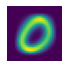

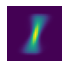

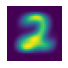

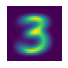

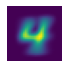

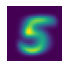

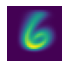

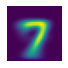

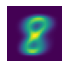

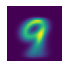

In [8]:
for i in range(10):
    paths = (path / 'training' / '{}'.format(i)).ls().sorted()
    tensor_indiv = [tensor(Image.open(p)) for p in paths]
    ndata[i] = {}
    ndata[i]['tensor_stack'] = torch.stack(tensor_indiv).float() / 255
    ndata[i]['tensor_mean'] = ndata[i]['tensor_stack'].mean(0)
    show_image(ndata[i]['tensor_mean'])

Okay, not bad progress for one night!  Next up: pg 140, figuring out distance from the average.  We've got `im8` from earlier, so let's try that.

In [9]:
im8

In [10]:
ndata[8]['tensor_stack'].size(), ndata[9]['tensor_mean'].size()

(torch.Size([5851, 28, 28]), torch.Size([28, 28]))

<AxesSubplot:>

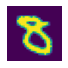

In [11]:
show_image(im8_t - ndata[8]['tensor_mean'])

Let's see if taking the mean difference does the trick:

In [12]:
for i in range(10):
    diff = (im8_t - ndata[i]['tensor_mean']).mean()
    print("im8 - {}: {}".format(i, diff))

im8 - 0: 55.30491638183594
im8 - 1: 55.40231704711914
im8 - 2: 55.329341888427734
im8 - 3: 55.33678436279297
im8 - 4: 55.35694885253906
im8 - 5: 55.34956359863281
im8 - 6: 55.34101486206055
im8 - 7: 55.36378860473633
im8 - 8: 55.32815933227539
im8 - 9: 55.35573959350586


Huh...first of all, zero is the closest match (lowest difference), followed by 8.  Second, they're all *really* close.  Did I miss something?  Let's go back to the original....aha!  I forgot about mean *absolute* difference, and *root mean squared*.  Let's try again.

In [13]:
for i in range(10):
    l1_diff = (im8_t - ndata[i]['tensor_mean']).abs().mean()
    l2_diff = ((im8_t - ndata[i]['tensor_mean'])**2).mean().sqrt()
    print(i, l1_diff, l2_diff)

0 tensor(55.4415) tensor(111.7371)
1 tensor(55.4551) tensor(111.8267)
2 tensor(55.4441) tensor(111.7579)
3 tensor(55.4206) tensor(111.7357)
4 tensor(55.4443) tensor(111.7857)
5 tensor(55.4369) tensor(111.7665)
6 tensor(55.4288) tensor(111.7568)
7 tensor(55.4384) tensor(111.7835)
8 tensor(55.4317) tensor(111.7462)
9 tensor(55.4337) tensor(111.7744)


This is still really weird.  What's going on here?  Let's take a look at the average 8 with Pandas, like we did before:

In [14]:
df = pd.DataFrame(ndata[8]['tensor_mean'])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042,0.000146,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000052,0.000131,0.000306,0.000523,0.000912,0.001631,0.002182,0.003089,0.003394,0.003456,0.002774,0.001684,0.001235,0.001324,0.000745,0.000501,0.000164,0.000028,0.000000,0.000000
4,0.000000,0.000000,0.000021,0.000000,0.000000,0.000027,0.000129,0.000954,0.002995,0.007111,0.015124,0.029257,0.051305,0.081390,0.111440,0.131845,0.134542,0.117827,0.091799,0.065212,0.043178,0.025043,0.011749,0.005167,0.002347,0.001049,0.000357,0.000040
5,0.000000,0.000000,0.000000,0.000000,0.000033,0.000410,0.002219,0.007849,0.020884,0.046356,0.089147,0.163629,0.264151,0.371977,0.465476,0.526044,0.539430,0.500334,0.411611,0.305475,0.203752,0.124000,0.067980,0.033654,0.014151,0.005314,0.001153,0.000032
6,0.000000,0.000000,0.000000,0.000000,0.000483,0.002475,0.010285,0.029995,0.070067,0.135887,0.236548,0.371098,0.509215,0.623946,0.697022,0.730529,0.724861,0.686317,0.602463,0.487167,0.356250,0.236846,0.141929,0.076771,0.034013,0.012367,0.002594,0.000217
7,0.000000,0.000000,0.000000,0.000064,0.002210,0.008659,0.027718,0.070105,0.141110,0.245296,0.379738,0.518490,0.618694,0.660528,0.648303,0.627855,0.608056,0.599911,0.590380,0.532148,0.430145,0.309680,0.199834,0.116783,0.054332,0.017322,0.003773,0.000320
8,0.000000,0.000000,0.000000,0.000893,0.005261,0.017767,0.049708,0.110292,0.202361,0.332076,0.470365,0.565895,0.594329,0.541709,0.451761,0.395156,0.393332,0.434783,0.501470,0.521458,0.453216,0.346357,0.237076,0.139555,0.066911,0.022379,0.004549,0.000487
9,0.000000,0.000000,0.000000,0.001215,0.008087,0.024644,0.065079,0.135225,0.245898,0.382396,0.502687,0.549436,0.506476,0.389927,0.278163,0.232206,0.275027,0.372516,0.479408,0.523295,0.465601,0.352535,0.234077,0.136494,0.063976,0.021182,0.004424,0.000460


Well, that looks good...but all the values are reals, in the range 0..1.  im8 by contrast is between 0 & 255.  Let's try a random image from the stacked version to make sure I got things right.

<AxesSubplot:>

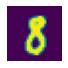

In [15]:
test_8 = ndata[8]['tensor_stack'][42]
show_image(test_8)

In [16]:
for i in range(10):
    l1_diff = (test_8 - ndata[i]['tensor_mean']).abs().mean()
    l2_diff = ((test_8 - ndata[i]['tensor_mean'])**2).mean().sqrt()
    print(i, l1_diff, l2_diff)

0 tensor(0.1823) tensor(0.3155)
1 tensor(0.1215) tensor(0.2784)
2 tensor(0.1569) tensor(0.2739)
3 tensor(0.1258) tensor(0.2303)
4 tensor(0.1626) tensor(0.3028)
5 tensor(0.1403) tensor(0.2531)
6 tensor(0.1553) tensor(0.2870)
7 tensor(0.1527) tensor(0.2944)
8 tensor(0.1226) tensor(0.2224)
9 tensor(0.1409) tensor(0.2714)


*That's* better!



Let's make a function for that.

In [17]:
def l1_diff(image_tensor):
    l1_diffs = {}
    lowest_diff = 1
    best_guess = -1
    for i in range(10):
        l1_diff = (image_tensor - ndata[i]['tensor_mean']).abs().mean()
        if l1_diff < lowest_diff:
            lowest_diff = l1_diff
            best_guess = i
        l1_diffs[i] = l1_diff
    return best_guess, l1_diffs

def l2_diff(image_tensor):
    l2_diffs = {}
    lowest_diff = 1
    for i in range(10):
        l2_diff = ((image_tensor - ndata[i]['tensor_mean'])**2).mean().sqrt()
        if l2_diff < lowest_diff:
            lowest_diff = l2_diff
            best_guess = i
        l2_diffs[i] = l2_diff
    return best_guess, l2_diffs

In [18]:
guess, table = l1_diff(test_8)
print("l1 diff best guess:", guess)
print("Table: ", table)
print()

guess, table = l2_diff(test_8)
print("l2 diff best guess:", guess)
print("Table: ", table)

l1 diff best guess: 1
Table:  {0: tensor(0.1823), 1: tensor(0.1215), 2: tensor(0.1569), 3: tensor(0.1258), 4: tensor(0.1626), 5: tensor(0.1403), 6: tensor(0.1553), 7: tensor(0.1527), 8: tensor(0.1226), 9: tensor(0.1409)}

l2 diff best guess: 8
Table:  {0: tensor(0.3155), 1: tensor(0.2784), 2: tensor(0.2739), 3: tensor(0.2303), 4: tensor(0.3028), 5: tensor(0.2531), 6: tensor(0.2870), 7: tensor(0.2944), 8: tensor(0.2224), 9: tensor(0.2714)}


Right, and PyTorch has these!

In [19]:
for i in range(10):
    # print("l1 {}: {}".format(i, F.l1_loss(test_8, ndata[i]['tensor_mean'])))
    print("l2 {}: {}".format(i, F.mse_loss(test_8, ndata[i]['tensor_mean']).sqrt()))
          

l2 0: 0.31545567512512207
l2 1: 0.2783662676811218
l2 2: 0.27391108870506287
l2 3: 0.23034287989139557
l2 4: 0.30281949043273926
l2 5: 0.25313061475753784
l2 6: 0.28700628876686096
l2 7: 0.29442763328552246
l2 8: 0.22235290706157684
l2 9: 0.271424263715744


Okay, time to try the validation data.

In [20]:
valid_ndata = list(range(10)) # This will hold all the validation everythings
for i in range(10):
    paths = (path / 'testing' / '{}'.format(i)).ls().sorted()
    tensor_indiv = [tensor(Image.open(p)) for p in paths]
    valid_ndata[i] = {}
    valid_ndata[i]['tensor_stack'] = torch.stack(tensor_indiv).float() / 255

In [21]:
valid_ndata[8]['tensor_stack'].shape

torch.Size([974, 28, 28])

Let's make tensor-fied versions of our distance functions:

In [22]:
def mnist_l1_dist(a, b):
    return (a-b).abs().mean((-1, -2))

def mnist_l2_dist(a, b):
    return ((a-b)**2).mean((-1, -2)).sqrt()

In [23]:
mnist_l2_dist(valid_ndata[8]['tensor_stack'], ndata[8]['tensor_mean'])

tensor([0.2013, 0.2244, 0.2193, 0.2073, 0.2543, 0.2633, 0.2204, 0.2435, 0.2059,
        0.2228, 0.3478, 0.2294, 0.2068, 0.2116, 0.2639, 0.2403, 0.2978, 0.2371,
        0.2860, 0.2412, 0.2633, 0.2417, 0.2141, 0.2203, 0.2640, 0.2800, 0.2084,
        0.2555, 0.2723, 0.2380, 0.2349, 0.2057, 0.2153, 0.2296, 0.3177, 0.2124,
        0.2118, 0.2925, 0.2007, 0.2195, 0.2414, 0.2316, 0.1989, 0.2780, 0.2436,
        0.2485, 0.2563, 0.2431, 0.2526, 0.1999, 0.2120, 0.2626, 0.2473, 0.2143,
        0.3035, 0.2361, 0.2491, 0.2227, 0.2936, 0.2141, 0.2665, 0.1959, 0.2549,
        0.2931, 0.2414, 0.1944, 0.2042, 0.2280, 0.2066, 0.2558, 0.1962, 0.2577,
        0.2238, 0.2150, 0.2238, 0.2584, 0.2127, 0.2318, 0.2333, 0.2839, 0.1886,
        0.2501, 0.2040, 0.2928, 0.2585, 0.2122, 0.2413, 0.3108, 0.2160, 0.2318,
        0.2943, 0.2143, 0.2542, 0.2201, 0.2350, 0.2278, 0.2891, 0.2068, 0.2652,
        0.2961, 0.2683, 0.2606, 0.2266, 0.2154, 0.2209, 0.2173, 0.2585, 0.2194,
        0.2161, 0.2350, 0.2607, 0.2507, 

Okay:  so now, we can get a properly broadcasted, tensorfied l1/l2 distance for each of our validation data set.  And that's good!  But the next part is tougher: determining which character we have, in a properly broadcasted, tensorfied manner.

Consider:  in the book, we were just trying to distinguish 3s from 7s, so all we had to do was find the minimum of two numbers:

```
def is_3(x)
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)
```

Now, though, we have to find the minimum of 10 distances.

Turns out PyTorch does this.  `min()` will return minimum along a dimension, *and* the indices where the minima were found.  Example:

In [24]:
a = torch.randn(4, 4)
print(a)
torch.min(a, 1)[1]

tensor([[ 1.9269,  1.4873,  0.9007, -2.1055],
        [ 0.6784, -1.2345, -0.0431, -1.6047],
        [-0.7521,  1.6487, -0.3925, -1.4036],
        [-0.7279, -0.5594, -0.7688,  0.7624]])


tensor([3, 3, 3, 2])

So if we unsqueeze the testing set...

In [25]:
valid_ndata[9]['tensor_stack'].unsqueeze(1).size()

torch.Size([1009, 1, 28, 28])

...and convert the average images to a single tensor...

torch.Size([10, 28, 28])

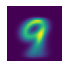

In [26]:
all_average_imgs = torch.zeros(10, 28, 28)
for i in range(1, 10):
    all_average_imgs[i] = ndata[i]['tensor_mean']

show_image(all_average_imgs[9])
all_average_imgs.shape

Okay, so let's give this a try on 9s to start with.

First, let's call `mnist_l1_distance` on the testing 9s, and examine the shape:

In [27]:
example_9_l1_dist = mnist_l1_dist(valid_ndata[9]['tensor_stack'].unsqueeze(1), all_average_imgs)
example_9_l1_dist.shape

torch.Size([1009, 10])

Looking good!  Let's examine one of the lines.  (Probably slightly misleading term, but I'm stuck for a better one right now.)

In [28]:
example_9_l1_dist[123]

tensor([0.1528, 0.1697, 0.1947, 0.1752, 0.1505, 0.1774, 0.1745, 0.1608, 0.1870,
        0.1461])

Cool!  And the min trick?

In [29]:
example_9_l1_dist[123].min(-1)

torch.return_types.min(
values=tensor(0.1461),
indices=tensor(9))

Looks like it got that one right!  Let's see how the whole thing did:

In [30]:
example_9_l1_dist.min(-1)[1]

tensor([1, 9,  ..., 0, 9])

Sweet!  And can we turn that into an accuracy?

In [31]:
example_9_l1_dist.min(-1)[1] == 9

tensor([False,  True,  ..., False,  True])

Looks good....

In [32]:
example_9_right_or_wrong = (example_9_l1_dist.min(-1)[1] == 9)
example_9_right_or_wrong.shape

torch.Size([1009])

Still looking good!  Now to turn it into an accuracy:

In [33]:
example_9_right_or_wrong.float().mean()

tensor(0.6244)

Huzzah!  Although that's not real good...But at any rate: on to the rest of the numbers.

First, l1 distance:

In [34]:
for i in range(10):
    row_to_validate = valid_ndata[i]['tensor_stack'].unsqueeze(1)
    predictions = mnist_l1_dist(row_to_validate, all_average_imgs).min(-1)[1]
    accuracy = (predictions == i).float().mean()
    print("{}: Accuracy {}%".format(i, accuracy * 100))

0: Accuracy 41.020408630371094%
1: Accuracy 69.42731475830078%
2: Accuracy 38.372093200683594%
3: Accuracy 54.85148620605469%
4: Accuracy 42.769859313964844%
5: Accuracy 23.991031646728516%
6: Accuracy 64.09185791015625%
7: Accuracy 54.280155181884766%
8: Accuracy 44.35318374633789%
9: Accuracy 62.43805694580078%


And now l2 accuracy:

In [35]:
for i in range(10):
    row_to_validate = valid_ndata[i]['tensor_stack'].unsqueeze(1)
    predictions = mnist_l2_dist(row_to_validate, all_average_imgs).min(-1)[1]
    accuracy = (predictions == i).float().mean()
    print("{}: Accuracy {}%".format(i, accuracy * 100))

0: Accuracy 0.20408162474632263%
1: Accuracy 95.68281555175781%
2: Accuracy 76.8410873413086%
3: Accuracy 80.79208374023438%
4: Accuracy 82.38289642333984%
5: Accuracy 68.60986328125%
6: Accuracy 87.26513671875%
7: Accuracy 83.07392883300781%
8: Accuracy 74.33264923095703%
9: Accuracy 80.77304077148438%


Wow: l2 is a *lot* better, with the exception of 0.  I wonder why that is...

# TODO

Now do it with neural nets!